# Setup & Import

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
!unzip -q "/content/drive/MyDrive/project-dataset/11-785-fall-20-homework-2-part-2.zip" -d /content/data

In [3]:
# ============================================================
# 0. Common setup
# ============================================================
import os, numpy as np, pandas as pd, tensorflow as tf
import keras
from keras import layers, Model
from sklearn.metrics import roc_curve, auc

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

# Mixed precision (great for A100) - cho supervised
from keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
try:
    tf.config.optimizer.set_jit(False)  # keep off if you had issues
except Exception:
    pass

# ---------------- Paths ----------------
BASE = "/content/data"
CLF_DIR = os.path.join(BASE, "classification_data")
TRAIN_DIR = os.path.join(CLF_DIR, "train_data")
VAL_DIR   = os.path.join(CLF_DIR, "val_data")
TEST_DIR  = os.path.join(CLF_DIR, "test_data")

VERIF_DIR = os.path.join(BASE, "verification_data")
PAIRS_TXT = os.path.join(BASE, "verification_pairs_val.txt")

CACHE_DIR = "/content/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

AUTO = tf.data.AUTOTUNE

# Global vars (will be overwritten per phase)
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

TensorFlow: 2.19.0
Keras: 3.10.0


# Preprocess, Augmentation and Utilities

In [4]:
# ============================================================
# 1. Preprocess + augmentation + utils
# ============================================================

def preprocess_img(path):
    """Load & preprocess a single image path (uses global IMG_SIZE)."""
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def cosine_sim(a, b):
    a = a / (np.linalg.norm(a, axis=-1, keepdims=True) + 1e-9)
    b = b / (np.linalg.norm(b, axis=-1, keepdims=True) + 1e-9)
    return np.sum(a * b, axis=-1)

def euclidean_dist(a, b):
    return np.linalg.norm(a - b, axis=-1)

def make_clf_ds(root, subset="training"):
    """Build tf.data pipeline for classification."""
    ds = tf.keras.utils.image_dataset_from_directory(
        root,
        labels="inferred",
        label_mode="categorical",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    if subset == "training":
        aug = keras.Sequential(
            [
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.05),
                layers.RandomZoom(0.1),
                layers.RandomContrast(0.1),
            ],
            name="aug"
        )
        ds = ds.map(
            lambda x, y: (aug(x, training=True), y),
            num_parallel_calls=AUTO
        )

    return ds.prefetch(AUTO)

def embed_paths(paths, model):
    """Embed a list of image paths using a model → (N, D) array."""
    out = []
    batch = []
    for p in paths:
        batch.append(preprocess_img(p))
        if len(batch) == BATCH_SIZE:
            batch_tensor = tf.stack(batch, axis=0)
            out.append(model.predict(batch_tensor, verbose=0))
            batch = []
    if batch:
        batch_tensor = tf.stack(batch, axis=0)
        out.append(model.predict(batch_tensor, verbose=0))
    return np.vstack(out)

def roc_auc_and_best_t(scores, labels):
    fpr, tpr, th = roc_curve(labels, scores)
    AUC = auc(fpr, tpr)
    J = tpr - fpr
    best_idx = np.argmax(J)
    return {
        "fpr": fpr,
        "tpr": tpr,
        "th": th,
        "auc": AUC,
        "best_t": th[best_idx],
        "tpr_at_best": tpr[best_idx],
        "fpr_at_best": fpr[best_idx],
    }


# Hybrid Backbone

In [5]:
# ============================================================
# 2. Hybrid backbone: EffNetB4 + CBAM + tiny ViT
# ============================================================

def cbam_block(x, r=8, name="cbam"):
    """CBAM block, with Lambda layers given explicit output_shape for Keras 3."""
    in_channels = int(x.shape[-1])

    # ----- Channel attention -----
    gap = layers.GlobalAveragePooling2D(keepdims=True)(x)
    gmp = layers.GlobalMaxPooling2D(keepdims=True)(x)

    def mlp(pool):
        h = layers.Conv2D(
            max(in_channels // r, 16), 1,
            activation="relu",
            dtype="float32"
        )(pool)
        h = layers.Conv2D(
            in_channels, 1,
            activation="sigmoid",
            dtype="float32"
        )(h)
        return h

    ca = layers.Add(name=f"{name}_ca_add")([mlp(gap), mlp(gmp)])
    x = layers.Multiply(name=f"{name}_ca_mul")([x, ca])

    # ----- Spatial attention (FIXED Lambda with output_shape) -----
    def avg_fn(t):
        return tf.reduce_mean(t, axis=-1, keepdims=True)

    def max_fn(t):
        return tf.reduce_max(t, axis=-1, keepdims=True)

    def sp_out_shape(input_shape):
        # (B, H, W, C) -> (B, H, W, 1)
        return (input_shape[0], input_shape[1], input_shape[2], 1)

    avg = layers.Lambda(
        avg_fn,
        output_shape=sp_out_shape,
        name=f"{name}_sp_avg"
    )(x)

    mx = layers.Lambda(
        max_fn,
        output_shape=sp_out_shape,
        name=f"{name}_sp_max"
    )(x)

    s = layers.Concatenate(axis=-1, name=f"{name}_sp_concat")([avg, mx])
    s = layers.Conv2D(
        1,
        kernel_size=7,
        padding="same",
        activation="sigmoid",
        dtype="float32",
        name=f"{name}_sp_conv"
    )(s)
    x = layers.Multiply(name=f"{name}_sp_mul")([x, s])
    return x

# Đăng ký lớp custom để sau này load không cần custom_objects (nếu muốn)
@keras.saving.register_keras_serializable(package="custom")
class TransformerBlock(layers.Layer):
    """Tiny ViT-like encoder block over CNN tokens."""
    def __init__(
        self,
        d_model,
        num_heads,
        mlp_dim,
        attn_drop=0.0,
        proj_drop=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop

        self.norm1 = layers.LayerNormalization(epsilon=1e-6, dtype="float32")
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=attn_drop,
            dtype="float32",
        )
        self.drop1 = layers.Dropout(proj_drop)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6, dtype="float32")
        self.ffn = keras.Sequential(
            [
                layers.Dense(mlp_dim, activation="gelu", dtype="float32"),
                layers.Dropout(proj_drop),
                layers.Dense(d_model, dtype="float32"),
                layers.Dropout(proj_drop),
            ]
        )

    def call(self, x, training=False):
        h = self.norm1(x)
        h = self.mha(h, h, training=training)
        h = self.drop1(h, training=training)
        x = layers.Add()([x, h])

        h2 = self.norm2(x)
        h2 = self.ffn(h2, training=training)
        return layers.Add()([x, h2])

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "d_model": self.d_model,
                "num_heads": self.num_heads,
                "mlp_dim": self.mlp_dim,
                "attn_drop": self.attn_drop,
                "proj_drop": self.proj_drop,
            }
        )
        return config

def vit_head_from_cnn(
    feat,
    d_model=512,
    depth=3,
    heads=8,
    mlp_dim=1024,
    dropout=0.1,
    name="vit_head",
):
    """CNN feature map (B,H,W,C) -> tokens -> ViT blocks -> pooled embedding."""
    C = int(feat.shape[-1])
    x = layers.Reshape((-1, C), name=f"{name}_reshape")(feat)
    x = layers.Dense(d_model, dtype="float32", name=f"{name}_proj")(x)

    for i in range(depth):
        x = TransformerBlock(
            d_model,
            heads,
            mlp_dim,
            attn_drop=dropout,
            proj_drop=dropout,
            name=f"{name}_block_{i}",
        )(x)

    x = layers.GlobalAveragePooling1D(name=f"{name}_gap")(x)
    return x

def build_hybrid_backbone(
    img_shape=(None, None, 3),
    emb_dim=512,
    effnet="B4",
    cbam_after=2,
    vit_d_model=512,
    vit_depth=3,
    vit_heads=8,
    vit_mlp=1024,
    vit_dropout=0.1,
):
    EffDict = {
        "B0": tf.keras.applications.EfficientNetB0,
        "B1": tf.keras.applications.EfficientNetB1,
        "B2": tf.keras.applications.EfficientNetB2,
        "B3": tf.keras.applications.EfficientNetB3,
        "B4": tf.keras.applications.EfficientNetB4,
    }
    base = EffDict[effnet](
        include_top=False,
        input_shape=img_shape,
        weights="imagenet",
    )
    x = base.output

    for i in range(cbam_after):
        x = cbam_block(x, r=8, name=f"cbam_{i}")

    z = vit_head_from_cnn(
        x,
        d_model=vit_d_model,
        depth=vit_depth,
        heads=vit_heads,
        mlp_dim=vit_mlp,
        dropout=vit_dropout,
        name="vit_head",
    )

    emb = layers.Dense(
        emb_dim,
        activation=None,
        name="embedding",
        dtype="float32",
    )(z)

    model = keras.Model(base.input, emb, name=f"hybrid_Eff{effnet}_CBAM_ViT")
    return model



# Supervised Classification

In [10]:
# ============================================================
# 2. Hybrid backbone: EffNetB4 + CBAM + tiny ViT
# ============================================================

# --- Lambda helper functions: đăng ký để load model không lỗi ---

@keras.saving.register_keras_serializable(package="custom")
def avg_fn(t):
    # (B, H, W, C) -> (B, H, W, 1)
    return tf.reduce_mean(t, axis=-1, keepdims=True)

@keras.saving.register_keras_serializable(package="custom")
def max_fn(t):
    # (B, H, W, C) -> (B, H, W, 1)
    return tf.reduce_max(t, axis=-1, keepdims=True)

@keras.saving.register_keras_serializable(package="custom")
def sp_out_shape(input_shape):
    # (B, H, W, C) -> (B, H, W, 1)
    return (input_shape[0], input_shape[1], input_shape[2], 1)

def cbam_block(x, r=8, name="cbam"):
    """CBAM block, with Lambda layers given explicit output_shape for Keras 3."""
    in_channels = int(x.shape[-1])

    # ----- Channel attention -----
    gap = layers.GlobalAveragePooling2D(keepdims=True)(x)
    gmp = layers.GlobalMaxPooling2D(keepdims=True)(x)

    def mlp(pool):
        h = layers.Conv2D(
            max(in_channels // r, 16), 1,
            activation="relu",
            dtype="float32"
        )(pool)
        h = layers.Conv2D(
            in_channels, 1,
            activation="sigmoid",
            dtype="float32"
        )(h)
        return h

    ca = layers.Add(name=f"{name}_ca_add")([mlp(gap), mlp(gmp)])
    x = layers.Multiply(name=f"{name}_ca_mul")([x, ca])

    # ----- Spatial attention (use registered functions) -----
    avg = layers.Lambda(
        avg_fn,
        output_shape=sp_out_shape,
        name=f"{name}_sp_avg"
    )(x)

    mx = layers.Lambda(
        max_fn,
        output_shape=sp_out_shape,
        name=f"{name}_sp_max"
    )(x)

    s = layers.Concatenate(axis=-1, name=f"{name}_sp_concat")([avg, mx])
    s = layers.Conv2D(
        1,
        kernel_size=7,
        padding="same",
        activation="sigmoid",
        dtype="float32",
        name=f"{name}_sp_conv"
    )(s)
    x = layers.Multiply(name=f"{name}_sp_mul")([x, s])
    return x

# Đăng ký lớp custom để sau này load không cần custom_objects (nếu muốn)
@keras.saving.register_keras_serializable(package="custom")
class TransformerBlock(layers.Layer):
    """Tiny ViT-like encoder block over CNN tokens."""
    def __init__(
        self,
        d_model,
        num_heads,
        mlp_dim,
        attn_drop=0.0,
        proj_drop=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.attn_drop = attn_drop
        self.proj_drop = proj_drop

        self.norm1 = layers.LayerNormalization(epsilon=1e-6, dtype="float32")
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=attn_drop,
            dtype="float32",
        )
        self.drop1 = layers.Dropout(proj_drop)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6, dtype="float32")
        self.ffn = keras.Sequential(
            [
                layers.Dense(mlp_dim, activation="gelu", dtype="float32"),
                layers.Dropout(proj_drop),
                layers.Dense(d_model, dtype="float32"),
                layers.Dropout(proj_drop),
            ]
        )

    def call(self, x, training=False):
        h = self.norm1(x)
        h = self.mha(h, h, training=training)
        h = self.drop1(h, training=training)
        x = layers.Add()([x, h])

        h2 = self.norm2(x)
        h2 = self.ffn(h2, training=training)
        return layers.Add()([x, h2])

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "d_model": self.d_model,
                "num_heads": self.num_heads,
                "mlp_dim": self.mlp_dim,
                "attn_drop": self.attn_drop,
                "proj_drop": self.proj_drop,
            }
        )
        return config

def vit_head_from_cnn(
    feat,
    d_model=512,
    depth=3,
    heads=8,
    mlp_dim=1024,
    dropout=0.1,
    name="vit_head",
):
    """CNN feature map (B,H,W,C) -> tokens -> ViT blocks -> pooled embedding."""
    C = int(feat.shape[-1])
    x = layers.Reshape((-1, C), name=f"{name}_reshape")(feat)
    x = layers.Dense(d_model, dtype="float32", name=f"{name}_proj")(x)

    for i in range(depth):
        x = TransformerBlock(
            d_model,
            heads,
            mlp_dim,
            attn_drop=dropout,
            proj_drop=dropout,
            name=f"{name}_block_{i}",
        )(x)

    x = layers.GlobalAveragePooling1D(name=f"{name}_gap")(x)
    return x

def build_hybrid_backbone(
    img_shape=(None, None, 3),
    emb_dim=512,
    effnet="B4",
    cbam_after=2,
    vit_d_model=512,
    vit_depth=3,
    vit_heads=8,
    vit_mlp=1024,
    vit_dropout=0.1,
):
    EffDict = {
        "B0": tf.keras.applications.EfficientNetB0,
        "B1": tf.keras.applications.EfficientNetB1,
        "B2": tf.keras.applications.EfficientNetB2,
        "B3": tf.keras.applications.EfficientNetB3,
        "B4": tf.keras.applications.EfficientNetB4,
    }
    base = EffDict[effnet](
        include_top=False,
        input_shape=img_shape,
        weights="imagenet",
    )
    x = base.output

    for i in range(cbam_after):
        x = cbam_block(x, r=8, name=f"cbam_{i}")

    z = vit_head_from_cnn(
        x,
        d_model=vit_d_model,
        depth=vit_depth,
        heads=vit_heads,
        mlp_dim=vit_mlp,
        dropout=vit_dropout,
        name="vit_head",
    )

    emb = layers.Dense(
        emb_dim,
        activation=None,
        name="embedding",
        dtype="float32",
    )(z)

    model = keras.Model(base.input, emb, name=f"hybrid_Eff{effnet}_CBAM_ViT")
    return model


# ============================================================
# 3. Classifier + 3-phase training
# ============================================================

def build_classifier(num_classes, emb_dim=512):
    backbone = build_hybrid_backbone(
        img_shape=(None, None, 3),
        emb_dim=emb_dim,
        effnet="B4",
        cbam_after=2,
        vit_d_model=512,
        vit_depth=3,
        vit_heads=8,
        vit_mlp=1024,
        vit_dropout=0.1,
    )

    for l in backbone.layers:
        l.trainable = False

    emb = backbone.output
    x = layers.BatchNormalization(dtype="float32")(emb)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(
        num_classes,
        activation="softmax",
        name="head",
        dtype="float32",
    )(x)

    clf = keras.Model(backbone.input, out, name="clf_hybrid_b4")
    emb_model = keras.Model(backbone.input, emb, name="emb_hybrid_b4")
    return clf, emb_model

def get_callbacks(name_prefix):
    ckpt_path = f"/content/{name_prefix}_best.keras"
    return [
        keras.callbacks.ModelCheckpoint(
            ckpt_path,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=False,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=2,
            min_lr=1e-6,
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True,
            verbose=1,
        ),
    ]

# --- Phase 1: head warmup (224x224, backbone frozen) ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
train_ds = make_clf_ds(TRAIN_DIR, "training")
val_ds   = make_clf_ds(VAL_DIR, "validation")

num_classes = train_ds.element_spec[1].shape[-1]
clf, emb_model = build_classifier(num_classes, emb_dim=512)

clf.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)

clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=200,
    validation_steps=60,
    callbacks=get_callbacks("phase1"),
)

# --- Phase 2: unfreeze top ~1/3 (256x256) ---
IMG_SIZE = (256, 256)
BATCH_SIZE = 48
train_ds = make_clf_ds(TRAIN_DIR, "training")
val_ds   = make_clf_ds(VAL_DIR, "validation")

total_layers = len(clf.layers)
for i, l in enumerate(clf.layers):
    if i > total_layers * 2 // 3:
        l.trainable = True

clf.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)

clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=220,
    validation_steps=60,
    callbacks=get_callbacks("phase2"),
)

# --- Phase 3: unfreeze all (320x320) ---
IMG_SIZE = (320, 320)
BATCH_SIZE = 32
train_ds = make_clf_ds(TRAIN_DIR, "training")
val_ds   = make_clf_ds(VAL_DIR, "validation")

for l in clf.layers:
    l.trainable = True

clf.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)

clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=240,
    validation_steps=60,
    callbacks=get_callbacks("phase3"),
)

# Save final classifier + supervised embedding model
clf.save("/content/clf_hybrid_b4_final.keras")
emb_model = keras.Model(
    clf.input,
    clf.get_layer("embedding").output,
    name="emb_hybrid_b4_final",
)
emb_model.save("/content/emb_hybrid_b4_supervised.keras")

Found 380638 files belonging to 4000 classes.
Found 8000 files belonging to 4000 classes.
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 205ms/step - accuracy: 0.0012 - loss: 8.4820 - val_accuracy: 0.0055 - val_loss: 8.4437 - learning_rate: 0.0010
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.0052 - loss: 8.2613 - val_accuracy: 0.0083 - val_loss: 8.2701 - learning_rate: 0.0010
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.0084 - loss: 7.9855 - val_accuracy: 0.0091 - val_loss: 8.0578 - learning_rate: 0.0010
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.0083 - loss: 7.8203 - val_accuracy: 0.0117 - val_loss: 7.9187 - learning_rate: 0.0010
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.0124 - loss: 7.7343 - val_accuracy: 0.0104 - val_loss: 7.8065 - learning_rate: 0.0010
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.0123 - loss: 7.6888 - val_accuracy: 0.0151 - val_loss: 7.7326 - le

In [11]:
# ============================================================
# 4. Supervised verification evaluation
# ============================================================

pairs = pd.read_csv(
    PAIRS_TXT,
    delim_whitespace=True,
    header=None,
    names=["p1", "p2", "label"],
)
pairs["p1"] = pairs["p1"].apply(lambda p: os.path.join(BASE, p))
pairs["p2"] = pairs["p2"].apply(lambda p: os.path.join(BASE, p))
labels = pairs["label"].values

IMG_SIZE = (320, 320)   # use high-res for eval
BATCH_SIZE = 64

emb1_sup = embed_paths(pairs["p1"].tolist(), emb_model)
emb2_sup = embed_paths(pairs["p2"].tolist(), emb_model)

cos_scores_sup = cosine_sim(emb1_sup, emb2_sup)
euc_scores_sup = -euclidean_dist(emb1_sup, emb2_sup)

res_cos_sup = roc_auc_and_best_t(cos_scores_sup, labels)
res_euc_sup = roc_auc_and_best_t(euc_scores_sup, labels)

print(f"[Supervised] Cosine AUC: {res_cos_sup['auc']:.4f} | Best T: {res_cos_sup['best_t']:.4f}")
print(f"[Supervised] Euclid  AUC: {res_euc_sup['auc']:.4f} | Best T: {res_euc_sup['best_t']:.4f}")


/tmp/ipython-input-2321106152.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pairs = pd.read_csv(


[Supervised] Cosine AUC: 0.8532 | Best T: 0.5803
[Supervised] Euclid  AUC: 0.8811 | Best T: -610.1769


## Metric Learning


In [12]:
# ============================================================
# 5. METRIC LEARNING (ROBUST VERSION – NO NaN)
# ============================================================

from keras import mixed_precision
mixed_precision.set_global_policy("float32")   # dùng full float32
print("Metric precision policy:", mixed_precision.global_policy())

# --- Dataset cho metric learning ---
IMG_SIZE = (256, 256)
BATCH_SIZE = 64

train_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",           # integer class labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

class_names = getattr(train_raw, "class_names", None)
print("Metric learning classes:", len(class_names) if class_names is not None else "N/A")

def map_pp_metric(img, label):
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, tf.cast(label, tf.int32)

train_raw = (
    train_raw
    .map(map_pp_metric, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# --- Reload supervised embedding model under float32 ---
# Nếu bạn đã train trước đó và file tồn tại thì KHÔNG cần train lại.
sup_emb = keras.models.load_model(
    "/content/emb_hybrid_b4_supervised.keras",
    compile=False,
    custom_objects={
        "TransformerBlock": TransformerBlock,
        "avg_fn": avg_fn,
        "max_fn": max_fn,
        "sp_out_shape": sp_out_shape,
    },
)
print("Loaded supervised embedding model for metric learning.")
sup_emb.summary()

# --- Wrap với clean + L2-normalized head ---
inp = sup_emb.input
x = sup_emb.output

def clean_fn(t):
    t = tf.cast(t, tf.float32)
    finite = tf.math.is_finite(t)
    return tf.where(finite, t, tf.zeros_like(t))

x = layers.Lambda(clean_fn, name="clean_emb")(x)
x = layers.Lambda(
    lambda t: tf.math.l2_normalize(t, axis=-1),
    name="l2_norm_emb"
)(x)

metric_backbone = keras.Model(inp, x, name="metric_backbone_hybrid")
metric_backbone.summary()

# Freeze phần lớn layer, fine-tune tail
total_layers = len(metric_backbone.layers)
freeze_upto = max(0, total_layers - 25)
for i, L in enumerate(metric_backbone.layers):
    if i < freeze_upto:
        L.trainable = False
frozen = sum(not L.trainable for L in metric_backbone.layers)
print(f"Frozen {frozen}/{total_layers} layers for metric learning.")

# --- Pairwise distance & batch-all triplet loss ---
@tf.function
def pairwise_distances(z, eps=1e-6):
    z = tf.cast(z, tf.float32)
    norm = tf.norm(z, axis=-1, keepdims=True)
    z_norm = z / (norm + eps)
    dot = tf.matmul(z_norm, z_norm, transpose_b=True)
    d = 1.0 - dot
    return tf.maximum(d, 0.0)

def batch_all_triplet_loss(labels, embeddings, margin=0.3):
    labels = tf.cast(labels, tf.int32)
    embeddings = tf.cast(embeddings, tf.float32)

    pd = pairwise_distances(embeddings)
    labels = tf.reshape(labels, (-1, 1))
    matches = tf.equal(labels, tf.transpose(labels))

    ap_mask = tf.cast(matches, tf.float32) - tf.eye(
        tf.shape(labels)[0], dtype=tf.float32
    )
    an_mask = 1.0 - tf.cast(matches, tf.float32)

    ap_dist = tf.expand_dims(pd, 2)
    an_dist = tf.expand_dims(pd, 1)
    triplet = ap_dist - an_dist + margin

    mask = tf.expand_dims(ap_mask, 2) * tf.expand_dims(an_mask, 1)
    triplet = triplet * mask
    triplet = tf.maximum(triplet, 0.0)

    valid = tf.cast(triplet > 1e-12, tf.float32)
    loss = tf.reduce_sum(triplet) / (tf.reduce_sum(valid) + 1e-9)
    return loss

# --- Custom training model ---
class TripletModel(keras.Model):
    def __init__(self, backbone, margin=0.3):
        super().__init__()
        self.backbone = backbone
        self.margin = margin

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z = self.backbone(x, training=True)
            z = tf.where(tf.math.is_finite(z), z, tf.zeros_like(z))
            loss = batch_all_triplet_loss(y, z, margin=self.margin)

        grads = tape.gradient(loss, self.backbone.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.backbone.trainable_variables)
        )
        return {"loss": loss}

triplet_model = TripletModel(metric_backbone, margin=0.3)
triplet_model.compile(
    optimizer=keras.optimizers.Adam(3e-5, clipnorm=1.0)
)

# Sanity check BEFORE training
for xb, yb in train_raw.take(1):
    z0 = metric_backbone(xb, training=False).numpy()
    print("NaN in metric backbone BEFORE training?",
          np.isnan(z0).any(), "| Inf?", np.isinf(z0).any())

history_metric = triplet_model.fit(
    train_raw,
    epochs=3,
    steps_per_epoch=150,
    verbose=1,
)

# Check AFTER training
for xb, yb in train_raw.take(1):
    zb = metric_backbone(xb, training=False).numpy()
    print("NaN in metric embeddings AFTER training?",
          np.isnan(zb).any(), "| Inf?", np.isinf(zb).any())

metric_backbone.save("/content/emb_metric_final.keras")
emb_metric = metric_backbone


Metric precision policy: <DTypePolicy "float32">
Found 380638 files belonging to 4000 classes.
Metric learning classes: 4000


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'vit_head_block_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'vit_head_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'vit_head_block_2', however the 

Loaded supervised embedding model for metric learning.


Model: "emb_hybrid_b4_final"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, None,      │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, None,      │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, None,      │          0 │ normalization_1[… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,296 │ stem_conv_pad[0]… │
│                     │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 48)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      1,152 │ block1a_se_excit

 Total params: 28,382,373 (108.27 MB)

 Trainable params: 28,257,166 (107.79 MB)

 Non-trainable params: 125,207 (489.09 KB)

Model: "metric_backbone_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, None,      │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, None,      │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, None,      │          0 │ normalization_1[… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,296 │ stem_conv_pad[0]… │
│                     │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 48)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 48)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      1,152 │ block1a_se_excit

 Total params: 28,382,373 (108.27 MB)

 Trainable params: 28,257,166 (107.79 MB)

 Non-trainable params: 125,207 (489.09 KB)

Frozen 485/510 layers for metric learning.
NaN in metric backbone BEFORE training? False | Inf? False
Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 135s 56ms/step - loss: 0.0772
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0782
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0909
NaN in metric embeddings AFTER training? False | Inf? False


In [13]:
# ============================================================
# 6. Metric-learning verification evaluation (Cosine + Euclid)
# ============================================================

IMG_SIZE = (320, 320)
BATCH_SIZE = 64

emb1_m = embed_paths(pairs["p1"].tolist(), emb_metric)
emb2_m = embed_paths(pairs["p2"].tolist(), emb_metric)

print("NaN in emb1_m?", np.isnan(emb1_m).any(), "| Inf?", np.isinf(emb1_m).any())
print("NaN in emb2_m?", np.isnan(emb2_m).any(), "| Inf?", np.isinf(emb2_m).any())

emb1_m = np.nan_to_num(emb1_m, nan=0.0, posinf=0.0, neginf=0.0)
emb2_m = np.nan_to_num(emb2_m, nan=0.0, posinf=0.0, neginf=0.0)

cos_scores_m = cosine_sim(emb1_m, emb2_m)
euc_scores_raw = euclidean_dist(emb1_m, emb2_m)
euc_scores_m = -euc_scores_raw

cos_scores_m = np.nan_to_num(cos_scores_m, nan=0.0, posinf=0.0, neginf=0.0)
euc_scores_m = np.nan_to_num(euc_scores_m, nan=0.0, posinf=0.0, neginf=0.0)

labels_clean = labels.astype(np.int32)

res_cos_m = roc_auc_and_best_t(cos_scores_m, labels_clean)
res_euc_m = roc_auc_and_best_t(euc_scores_m, labels_clean)

print(f"[Metric] Cosine AUC: {res_cos_m['auc']:.4f} | Best T: {res_cos_m['best_t']:.4f}")
print(f"[Metric] Euclid AUC: {res_euc_m['auc']:.4f} | Best T: {res_euc_m['best_t']:.4f}")

NaN in emb1_m? False | Inf? False
NaN in emb2_m? False | Inf? False
[Metric] Cosine AUC: 0.8759 | Best T: 0.3845
[Metric] Euclid AUC: 0.8759 | Best T: -1.1095


In [14]:
# --- Verification accuracy at best threshold (Supervised + Euclid) ---
best_t_euc_sup = res_euc_sup["best_t"]
y_pred_euc_sup = (euc_scores_sup >= best_t_euc_sup).astype(int)
verif_acc_euc_sup = (y_pred_euc_sup == labels).mean()
print(f"[Supervised Euclid] Verif Accuracy @ best T: {verif_acc_euc_sup:.4f}")

# Optional: same for cosine
best_t_cos_sup = res_cos_sup["best_t"]
y_pred_cos_sup = (cos_scores_sup >= best_t_cos_sup).astype(int)
verif_acc_cos_sup = (y_pred_cos_sup == labels).mean()
print(f"[Supervised Cosine] Verif Accuracy @ best T: {verif_acc_cos_sup:.4f}")

# Optional: for metric learning
best_t_cos_m = res_cos_m["best_t"]
y_pred_cos_m = (cos_scores_m >= best_t_cos_m).astype(int)
verif_acc_cos_m = (y_pred_cos_m == labels).mean()
print(f"[Metric Cosine] Verif Accuracy @ best T: {verif_acc_cos_m:.4f}")


[Supervised Euclid] Verif Accuracy @ best T: 0.8073
[Supervised Cosine] Verif Accuracy @ best T: 0.7761
[Metric Cosine] Verif Accuracy @ best T: 0.7998


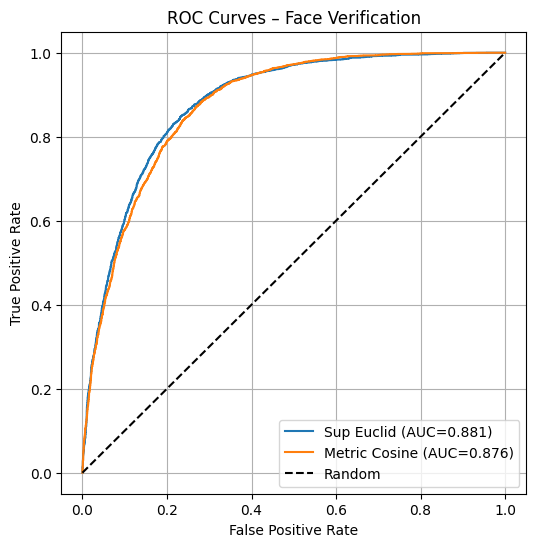

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Supervised Euclid
fpr_sup_e, tpr_sup_e, _ = roc_curve(labels, euc_scores_sup)
auc_sup_e = auc(fpr_sup_e, tpr_sup_e)

# Metric Cosine
fpr_m_cos, tpr_m_cos, _ = roc_curve(labels, cos_scores_m)
auc_m_cos = auc(fpr_m_cos, tpr_m_cos)

plt.figure(figsize=(6, 6))
plt.plot(fpr_sup_e, tpr_sup_e, label=f"Sup Euclid (AUC={auc_sup_e:.3f})")
plt.plot(fpr_m_cos, tpr_m_cos, label=f"Metric Cosine (AUC={auc_m_cos:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Face Verification")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Load test pairs
pairs_test = pd.read_csv(
    os.path.join(BASE, "verification_pairs_test.txt"),
    delim_whitespace=True,
    header=None,
    names=["p1", "p2"],
)

pairs_test["p1"] = pairs_test["p1"].apply(lambda p: os.path.join(BASE, p))
pairs_test["p2"] = pairs_test["p2"].apply(lambda p: os.path.join(BASE, p))

# Use your chosen model; example: supervised Euclid
emb1_test = embed_paths(pairs_test["p1"].tolist(), emb_model)      # or emb_metric
emb2_test = embed_paths(pairs_test["p2"].tolist(), emb_model)

cos_scores_test = cosine_sim(emb1_test, emb2_test)
euc_scores_test = -euclidean_dist(emb1_test, emb2_test)

# Either save raw scores, or apply best threshold to get 0/1 labels (depends on assignment)
sub = pd.read_csv(os.path.join(BASE, "hw2p2_sample_submission.csv"))
sub["score"] = cos_scores_test   # or euc_scores_test
sub.to_csv("my_submission.csv", index=False)
print("Saved my_submission.csv")


/tmp/ipython-input-4087591130.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pairs_test = pd.read_csv(


Saved my_submission.csv
